<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/cnn_siamese_network_with_glcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For using pre-trained models
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from skimage.feature import graycomatrix, graycoprops

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

Mounted at /content/drive


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_images_per_class=10, triplet_fraction=1.0):
        """
        Args:
            root_dir (str): Path to the root directory containing class folders.
            transform (callable, optional): Transform to be applied to the images.
            num_images_per_class (int): Max number of images per class to use.
            triplet_fraction (float): Fraction of the total possible triplets to use.
        """
        if not os.path.exists(root_dir):
            raise ValueError(f"Root directory {root_dir} does not exist.")
        if len(os.listdir(root_dir)) == 0:
            raise ValueError(f"Root directory {root_dir} is empty.")

        self.root_dir = root_dir
        self.transform = transform
        self.num_images_per_class = num_images_per_class
        self.triplet_fraction = triplet_fraction

        # Load dataset as a dictionary: class_name -> list of file paths
        self.class_to_images = {}
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                images = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
                if len(images) >= 2:  # Ensure at least 2 images per class
                    random.shuffle(images)
                    self.class_to_images[class_name] = images[:self.num_images_per_class]

        self.classes = list(self.class_to_images.keys())
        self.class_negatives = {
            class_name: [cls for cls in self.classes if cls != class_name]
            for class_name in self.classes
        }

        # Dynamically calculate possible triplets
        self.total_triplets = self.calculate_total_triplets()
        self.num_triplets_to_use = int(self.triplet_fraction * self.total_triplets)

    def calculate_total_triplets(self):
        """
        Calculate the total number of triplets possible based on the dataset.
        """
        total = 0
        for class_name, images in self.class_to_images.items():
            num_images = len(images)
            num_positive_pairs = num_images * (num_images - 1) // 2
            num_negative_classes = len(self.class_negatives[class_name])
            total += num_positive_pairs * num_negative_classes
        return total

    def __len__(self):
        """
        Number of triplets to return per epoch.
        """
        return self.num_triplets_to_use

    def __getitem__(self, index):
        """
        Generate a random triplet.
        """
        # Randomly select an anchor class and image
        anchor_class = random.choice(self.classes)
        anchor_images = self.class_to_images[anchor_class]
        anchor_path, positive_path = random.sample(anchor_images, 2)  # Ensure different anchor and positive

        # Randomly select a negative class and image
        negative_class = random.choice(self.class_negatives[anchor_class])
        negative_path = random.choice(self.class_to_images[negative_class])

        # Load images
        anchor_image = self.load_image(anchor_path)
        positive_image = self.load_image(positive_path)
        negative_image = self.load_image(negative_path)

        return anchor_image, positive_image, negative_image

    def load_image(self, image_path):
        """
        Load an image and apply the transform if provided.
        """
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image



# class SiameseNetwork(nn.Module):
#     def __init__(self, backbone_name=None):
#         """
#         Siamese network with a single backbone.

#         Args:
#             backbone1_name (str): Name of the backbone (e.g., 'resnet50').
#             embedding_dim (int): Dimension of the output embeddings.
#         """
#         super(SiameseNetwork, self).__init__()

#         # Initialize backbone 1 if provided
#         if backbone_name:
#             self.backbone = timm.create_model(backbone_name, pretrained=True)
#             self.backbone.reset_classifier(0)  # Remove classification head
#         else:
#             raise ValueError("A backbone model must be specified.")

#     def forward(self, input1, input2=None, input3=None):
#         """
#         Forward pass for one, two, or three inputs.

#         Args:
#             input1 (torch.Tensor): Anchor input.
#             input2 (torch.Tensor, optional): Positive input.
#             input3 (torch.Tensor, optional): Negative input.

#         Returns:
#             Embeddings (torch.Tensor): Embedding of the input(s).
#         """


#         if input2 is None and input3 is None:
#             return self.backbone(input1)

#         if input3 is None:
#             return self.backbone(input1), self.backbone(input2)

#         return self.backbone(input1), self.backbone(input2), self.backbone(input3)

class SiameseNetworkWithGLCM(nn.Module):
    def __init__(self, backbone_name=None, glcm_params=None):
        """
        Siamese network with a single backbone and GLCM feature extraction.

        Args:
            backbone_name (str): Name of the backbone (e.g., 'resnet50').
            glcm_params (dict, optional): Parameters for GLCM feature extraction.
        """
        super(SiameseNetworkWithGLCM, self).__init__()

        # Initialize backbone
        if backbone_name:
            self.backbone = timm.create_model(backbone_name, pretrained=True)
            self.backbone.reset_classifier(0)  # Remove classification head
            self.embedding_dim = self.backbone.num_features
        else:
            raise ValueError("A backbone model must be specified.")

        # Default GLCM parameters
        self.glcm_params = glcm_params or {
            'distances': [1],
            'angles': [0],
            'levels': 256
        }

        # Fully connected layer to combine backbone and GLCM features
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim + 4, 256),  # Combine backbone features + 4 GLCM features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)  # Reduce combined features to final embedding size
        )

    def compute_glcm_features(self, image, device):
        """
        Compute GLCM features (contrast, correlation, energy, homogeneity) from the image.
        Args:
            image (torch.Tensor): Grayscale image (shape: [H, W]).
            device (torch.device): The device to move the output tensor to.
        Returns:
            torch.Tensor: GLCM features as a vector (shape: [4]).
        """
        # Convert tensor to NumPy array
        image_np = image.cpu().numpy()
        image_np = np.clip(image_np, 0, self.glcm_params['levels'] - 1).astype(np.uint8)

        # Compute GLCM
        glcm = graycomatrix(
            image_np,
            distances=self.glcm_params['distances'],
            angles=self.glcm_params['angles'],
            levels=self.glcm_params['levels'],
            symmetric=True,
            normed=True
        )

        # Extract GLCM properties
        contrast = graycoprops(glcm, 'contrast').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
        energy = graycoprops(glcm, 'energy').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()

        # Return as a tensor on the correct device
        return torch.tensor([contrast, correlation, energy, homogeneity], dtype=torch.float32, device=device)

    def process_input(self, x, device):
        """
        Process a single input through the backbone and compute combined features with GLCM.
        Args:
            x (torch.Tensor): Input tensor (shape: [batch_size, 3, H, W]).
            device (torch.device): Device for tensor operations.
        Returns:
            torch.Tensor: Combined feature vector (shape: [batch_size, 128]).
        """
        # Backbone features
        backbone_features = self.backbone(x)  # Shape: (batch_size, embedding_dim)

        # Compute GLCM features for each image in the batch
        glcm_features = torch.stack([
            self.compute_glcm_features(x[i].mean(dim=0), device)  # Convert to grayscale and compute GLCM
            for i in range(x.size(0))
        ])  # Shape: (batch_size, 4)

        # Combine backbone and GLCM features
        combined_features = torch.cat((backbone_features, glcm_features), dim=1)  # Shape: (batch_size, embedding_dim + 4)

        # Final embedding
        return self.fc(combined_features)  # Shape: (batch_size, 128)

    def forward(self, input1, input2=None, input3=None):
        """
        Forward pass for one, two, or three inputs.
        Args:
            input1 (torch.Tensor): Anchor input.
            input2 (torch.Tensor, optional): Positive input.
            input3 (torch.Tensor, optional): Negative input.
        Returns:
            torch.Tensor or Tuple[torch.Tensor]: Embeddings of the input(s).
        """
        device = input1.device

        # Process single input
        if input2 is None and input3 is None:
            return self.process_input(input1, device)

        # Process two inputs
        if input3 is None:
            embedding1 = self.process_input(input1, device)
            embedding2 = self.process_input(input2, device)
            return embedding1, embedding2

        # Process three inputs
        embedding1 = self.process_input(input1, device)
        embedding2 = self.process_input(input2, device)
        embedding3 = self.process_input(input3, device)
        return embedding1, embedding2, embedding3


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        loss = torch.mean(F.relu(positive_distance - negative_distance + self.margin))
        return loss


# Data Loading
def load_data(batch_size=32, triplet_fraction=1.0, num_train_images_per_class=20, num_val_images_per_class=4):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = TripletDataset(root_dir='data/train', transform=train_transform, num_images_per_class=num_train_images_per_class, triplet_fraction=triplet_fraction)
    val_dataset = TripletDataset(root_dir='data/validation', transform=val_transform, num_images_per_class=num_val_images_per_class, triplet_fraction=triplet_fraction)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=4, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=4, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader

# Save model state for resume training
def save_checkpoint(model, optimizer, epoch, val_loss, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)

# Load model state for resuming training
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    return model, optimizer, epoch, val_loss

# Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_labels, all_predictions = [], []

    progress = tqdm(loader, desc="Training", leave=False)
    # Loop over batches
    for anchor, positive, negative in progress:
        # Move data to device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        with autocast():
            # Forward pass
            anchor_output, positive_output, negative_output = model(anchor, positive, negative)

            # Compute loss
            loss = criterion(anchor_output, positive_output, negative_output)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Validate the model
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        # Loop over batches
        for anchor, positive, negative in tqdm(loader, desc="Validation", leave=False):
            # Move data to device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            with autocast():
                # Forward pass
                anchor_output, positive_output, negative_output = model(anchor, positive, negative)

                # Compute loss
                loss = criterion(anchor_output, positive_output, negative_output)

            running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for key, values in metrics.items():
        plt.plot(values, label=key)
    plt.legend()
    plt.show()

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path=None):
    num_epochs = 50
    early_stopping_patience = 15
    early_stopping_counter = 0
    curr_val_loss = 1.0
    metrics = {"train_loss": [], "val_loss": []}
    start_epoch = 0

    # Resume training if a checkpoint is provided
    if resume_path:
        model, optimizer, start_epoch, val_loss = load_checkpoint(resume_path, model, optimizer)
        print(f"Resumed training from epoch {start_epoch} with best Val Loss: {val_loss:.4f}, lr: {optimizer.param_groups[0]['lr']}")

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss = validate_model(model, val_loader, criterion, device)

        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Save the best model
        if val_loss < curr_val_loss:
            curr_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, curr_val_loss, "small_lr_cnn_siamese_best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    plot_metrics(metrics)

In [ ]:
# Data Loading
train_loader, val_loader = load_data(batch_size=32, triplet_fraction=0.5, num_train_images_per_class=20, num_val_images_per_class=2)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

glcm_params = {
    'distances': [1, 2],
    'angles': [0],
    'levels': 32
}

# Initialize model
model = SiameseNetworkWithGLCM(
    backbone_name="tf_efficientnetv2_m_in21k",
    glcm_params=glcm_params
).to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_m_in21k to current tf_efficientnetv2_m.in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

In [ ]:
# Define optimizer, scheduler, and loss function
criterion = TripletLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Reduce LR when the monitored metric stops decreasing
    factor=0.1,          # Multiply LR by this factor
    patience=7,          # Number of epochs to wait before reducing LR
    threshold=1e-4,      # Minimum change to qualify as an improvement
    cooldown=2,          # Number of epochs to wait after reducing LR
    min_lr=1e-6          # Minimum learning rate
)
scaler = GradScaler()

<ipython-input-6-56e05a650ef3>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/268 [00:00<?, ?it/s]<ipython-input-3-669442f26e76>:312: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-3-669442f26e76>:340: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.4468
Val Loss: 0.3950
Epoch 2/50


Train Loss: 0.1826
Val Loss: 0.3580
Epoch 3/50


Train Loss: 0.0981
Val Loss: 0.6362
Epoch 4/50


Train Loss: 0.0658
Val Loss: 0.5717
Epoch 5/50


Train Loss: 0.0541
Val Loss: 0.3193
Epoch 6/50


Train Loss: 0.0400
Val Loss: 0.4863
Epoch 7/50


Train Loss: 0.0352
Val Loss: 0.5041
Epoch 8/50


Train Loss: 0.0533
Val Loss: 0.3376
Epoch 9/50


Train Loss: 0.0404
Val Loss: 0.6319
Epoch 10/50


Train Loss: 0.0318
Val Loss: 0.4529
Epoch 11/50


Train Loss: 0.0401
Val Loss: 0.6226
Epoch 12/50


Train Loss: 0.0322
Val Loss: 0.4243
Epoch 13/50


Train Loss: 0.0228
Val Loss: 1.1260
Epoch 14/50


Train Loss: 0.0223
Val Loss: 0.7309
Epoch 15/50


Train Loss: 0.0153
Val Loss: 0.4822
Epoch 16/50


Train Loss: 0.0107
Val Loss: 0.6347
Epoch 17/50


Train Loss: 0.0110
Val Loss: 1.0864
Epoch 18/50


Train Loss: 0.0091
Val Loss: 0.6774
Epoch 19/50


Train Loss: 0.0086
Val Loss: 0.6651
Epoch 20/50


Train Loss: 0.0064
Val Loss: 0.7381
Early stopping triggered.


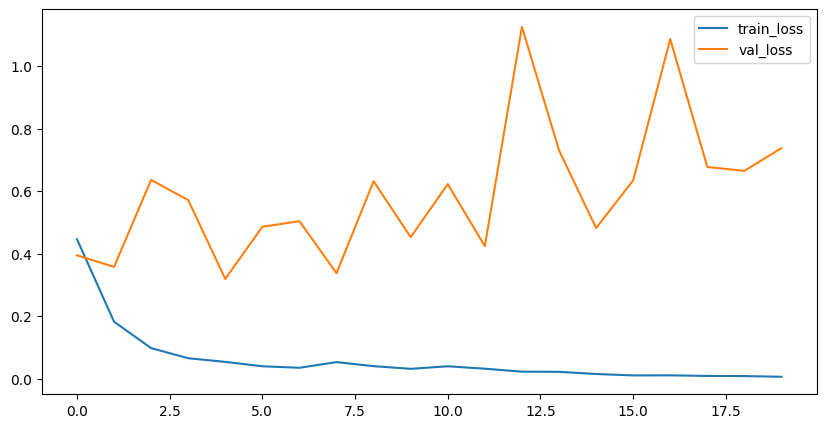

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device)

In [ ]:
# print state of model
model.state_dict()

In [ ]:
load_checkpoint("cnn_siamese_best_model.pth", model, optimizer)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, recall_score, precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def generate_embeddings(model, loader, device):
    """
    Generate embeddings and labels for all samples in the validation loader.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device to use for computation.

    Returns:
        embeddings (numpy.ndarray): Generated embeddings for all samples.
        labels (numpy.ndarray): Corresponding class labels.
    """
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for images, targets in loader:  # Assuming loader returns (image, label) tuples
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    return embeddings, labels

def compute_recall_at_k(embeddings, labels, k=5):
    """
    Compute Recall@K for the generated embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
        k (int): Number of nearest neighbors to consider.

    Returns:
        recall (float): Recall@K value.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    recall_at_k = []

    for i in range(len(labels)):
        # Get indices of the K nearest neighbors (excluding itself)
        neighbors = np.argsort(distances[i])[1:k+1]
        # Check if any neighbor has the same label
        recall_at_k.append(any(labels[i] == labels[neighbor] for neighbor in neighbors))

    return np.mean(recall_at_k)

def compute_map(embeddings, labels):
    """
    Compute Mean Average Precision (mAP) for the embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.

    Returns:
        mAP (float): Mean Average Precision score.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    average_precisions = []

    for i in range(len(labels)):
        # Get sorted indices based on distances
        neighbors = np.argsort(distances[i])
        relevant = 0
        precision_sum = 0.0

        for rank, neighbor in enumerate(neighbors[1:], start=1):  # Skip self-comparison
            if labels[i] == labels[neighbor]:
                relevant += 1
                precision_sum += relevant / rank

        if relevant > 0:
            average_precisions.append(precision_sum / relevant)

    return np.mean(average_precisions)



def visualize_embeddings(embeddings, labels):
    """
    Visualize embeddings using t-SNE.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
    """
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="tab10", s=5
    )
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

def evaluate_model(model, loader, device, k=5):
    """
    Evaluate the Siamese network.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device for computation.
        k (int): Number of neighbors for Recall@K.

    Returns:
        metrics (dict): Evaluation metrics including Recall@K and mAP.
    """
    embeddings, labels = generate_embeddings(model, loader, device)

    # Compute metrics
    recall = compute_recall_at_k(embeddings, labels, k)
    map_score = compute_map(embeddings, labels)

    print(f"Recall@{k}: {recall:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")

    # Visualize embeddings
    visualize_embeddings(embeddings, labels)

    return {"Recall@K": recall, "mAP": map_score}

In [ ]:
model = SiameseNetwork(
    backbone_name="tf_efficientnetv2_m_in21k",
).to(device)
load_checkpoint("cnn_siamese_best_model.pth", model, optimizer)

In [ ]:
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
test_dataset = datasets.ImageFolder(root='data/test', transform=val_transform)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=8, pin_memory=True)

Recall@5: 0.8703
Mean Average Precision (mAP): 0.4604


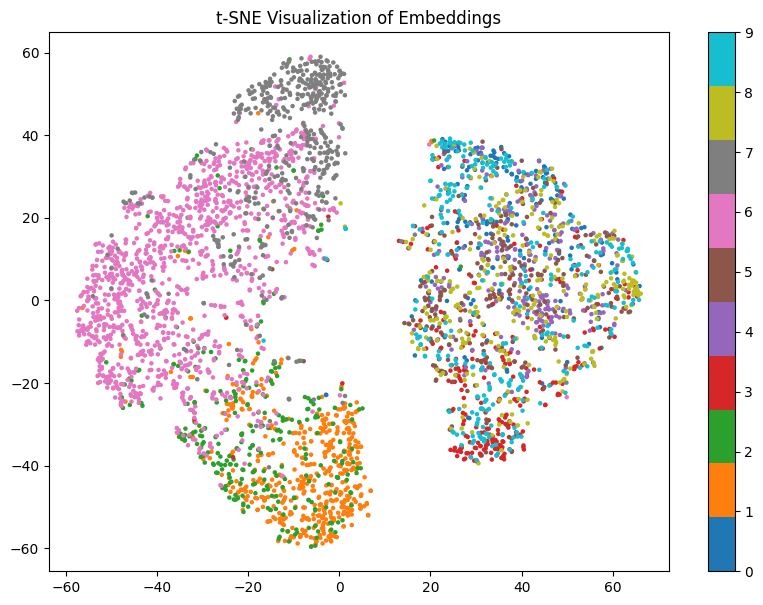

In [ ]:
metrics = evaluate_model(model, test_loader, device, k=5)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()